In [1]:
# Import necessary modules
import numpy as np
import pathlib
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2


In [2]:
# Set variable for file_path and data_dir
file_path = r"/Users/hemu/Desktop/Updated_work_on_Deep_Learning/Research_work_on_Deep_Learning/Pneumonia/chest_xray/Alzheimers_Image_data/dataset"
data_dir = pathlib.Path(file_path)



In [3]:
# Split train and validation data
SEED = 1234
BATCH_SIZE = 10
IMG_SIZE = (160, 160)

In [4]:

train_data = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                         validation_split=0.2,
                                                         subset='training',
                                                         seed=SEED,
                                                         image_size=IMG_SIZE,
                                                         batch_size=BATCH_SIZE,
                                                         shuffle=True
                                                         )


Found 6400 files belonging to 4 classes.
Using 5120 files for training.


In [5]:
val_data = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                       validation_split=0.2,
                                                       subset='validation',
                                                       seed=SEED,
                                                       image_size=IMG_SIZE,
                                                       batch_size=BATCH_SIZE,
                                                       shuffle=True
                                                       )


Found 6400 files belonging to 4 classes.
Using 1280 files for validation.


In [6]:
print(f"Total train data per batch: {len(train_data)}")
print(f"Total validation data per batch: {len(val_data)}")


Total train data per batch: 512
Total validation data per batch: 128


In [7]:
# Set variable for class_names
class_names = train_data.class_names


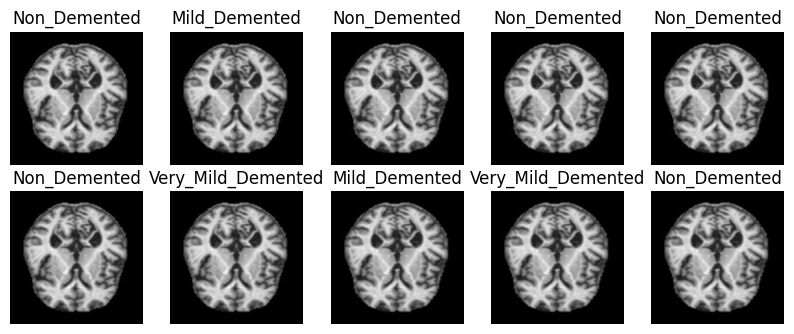

In [8]:
# Plot the train_data image
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
    for i in range(10):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[1].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis('off')

In [9]:
# Perform split of validation data into test data
val_batches = tf.data.experimental.cardinality(val_data)
test_data = val_data.take(val_batches // 2)
val_data = val_data.skip(val_batches // 2)


In [10]:
print(f"Number of validation batches: {tf.data.experimental.cardinality(val_data)}")
print(f"Number of test batches: {tf.data.experimental.cardinality(test_data)}")
print(f"Total train data: {len(train_data)}")
print(f"Total validation data: {len(val_data)}")
print(f"Total test data: {len(test_data)}")


Number of validation batches: 64
Number of test batches: 64
Total train data: 512
Total validation data: 64
Total test data: 64


In [11]:
# Create prefetch dataset for better performance
AUTOTUNE = tf.data.AUTOTUNE


In [12]:
train_data = train_data.prefetch(buffer_size=AUTOTUNE)
val_data = val_data.prefetch(buffer_size=AUTOTUNE)
test_data = test_data.prefetch(buffer_size=AUTOTUNE)


In [13]:
# Preprocess image input to rescale the image to fit into the pre-trained model
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
IMG_SHAPE = IMG_SIZE + (3,)


In [14]:
# Use MobileNetV2 as the base model
base_model = MobileNetV2(input_shape=IMG_SHAPE,
                         include_top=False,
                         weights=None
                         )
weights_path = '/Users/hemu/Desktop/Updated_work_on_Deep_Learning/Research_work_on_Deep_Learning/Pneumonia/chest_xray/Alzheimers_Image_data/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_160_no_top.h5'
base_model.load_weights(weights_path)

In [15]:
# Freeze the entire base_model
base_model.trainable = False
base_model.summary()


Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[

In [16]:
# Set variable for classifier layer
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()


In [17]:
# Set variable for output layer
nClass = len(class_names)
prediction_layer = tf.keras.layers.Dense(nClass, activation='softmax')


In [18]:
# Re-construct the model
inputs = tf.keras.Input(shape=(160, 160, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)


In [19]:
# Compile the model
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy']
              )


In [20]:
# Check the model
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 160, 160, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 160, 160, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                     

In [21]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [22]:
# Set up TensorBoard callback
import os
import datetime
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
es_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)


In [23]:
# Start training the model
initial_epochs = 1
history = model.fit(train_data,
                    epochs=initial_epochs,
                    validation_data=val_data,
                    callbacks=[tensorboard_callback, es_callback])


512/512 [==============================] - 25s 48ms/step - loss: 1.1231 - accuracy: 0.4713 - val_loss: 0.9654 - val_accuracy: 0.5531


In [24]:
# Perform fine-tuning of the trained model
# Unfreeze the top layers of the base model
base_model.trainable = True

In [25]:
# Fine-tune only a specific number of layers
fine_tune_at = 100  # Adjust the number of layers as needed


In [26]:
# Freeze all the layers before "fine_tune_at"
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Compile the model again with a lower learning rate
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate / 10),
              metrics=['accuracy'])


In [27]:
# Check the model again
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 160, 160, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 160, 160, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                     

In [28]:
# Resume model training from the last epochs
fine_tune_epochs = 30
total_epochs = initial_epochs + fine_tune_epochs

# Train the model again
history_fine_tune = model.fit(train_data,
                              epochs=total_epochs,
                              initial_epoch=history.epoch[-1],
                              validation_data=val_data,
                              callbacks=[tensorboard_callback, es_callback])


Epoch 1/31


512/512 [==============================] - 38s 71ms/step - loss: 0.9367 - accuracy: 0.5463 - val_loss: 0.8355 - val_accuracy: 0.6078
Epoch 2/31
512/512 [==============================] - 37s 73ms/step - loss: 0.8217 - accuracy: 0.6186 - val_loss: 0.8039 - val_accuracy: 0.6344
Epoch 3/31
512/512 [==============================] - 39s 75ms/step - loss: 0.7551 - accuracy: 0.6604 - val_loss: 0.7174 - val_accuracy: 0.6531
Epoch 4/31
512/512 [==============================] - 41s 79ms/step - loss: 0.6917 - accuracy: 0.6857 - val_loss: 0.6926 - val_accuracy: 0.6453
Epoch 5/31
512/512 [==============================] - 41s 80ms/step - loss: 0.6216 - accuracy: 0.7309 - val_loss: 0.6473 - val_accuracy: 0.7156
Epoch 6/31
512/512 [==============================] - 45s 88ms/step - loss: 0.5683 - accuracy: 0.7543 - val_loss: 0.6016 - val_accuracy: 0.7234
Epoch 7/31
512/512 [==============================] - 51s 100ms/step - loss: 0.5126 - accuracy: 0.7828 - val_loss: 0.6035 - val_accuracy: 0.7266
Ep

In [29]:
# Evaluate the model
print("-----------------------------------After Fine-tuning model..........................................")
model.evaluate(test_data)

-----------------------------------After Fine-tuning model..........................................
 1/64 [..............................] - ETA: 5s - loss: 0.8172 - accuracy: 0.9000

64/64 [==============================] - 63s 992ms/step - loss: 0.2802 - accuracy: 0.9187


[0.2801991403102875, 0.918749988079071]

In [30]:
# Use test data to make predictions
image_batch, label_batch = test_data.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)
class_predictions = np.argmax(predictions, axis=1)


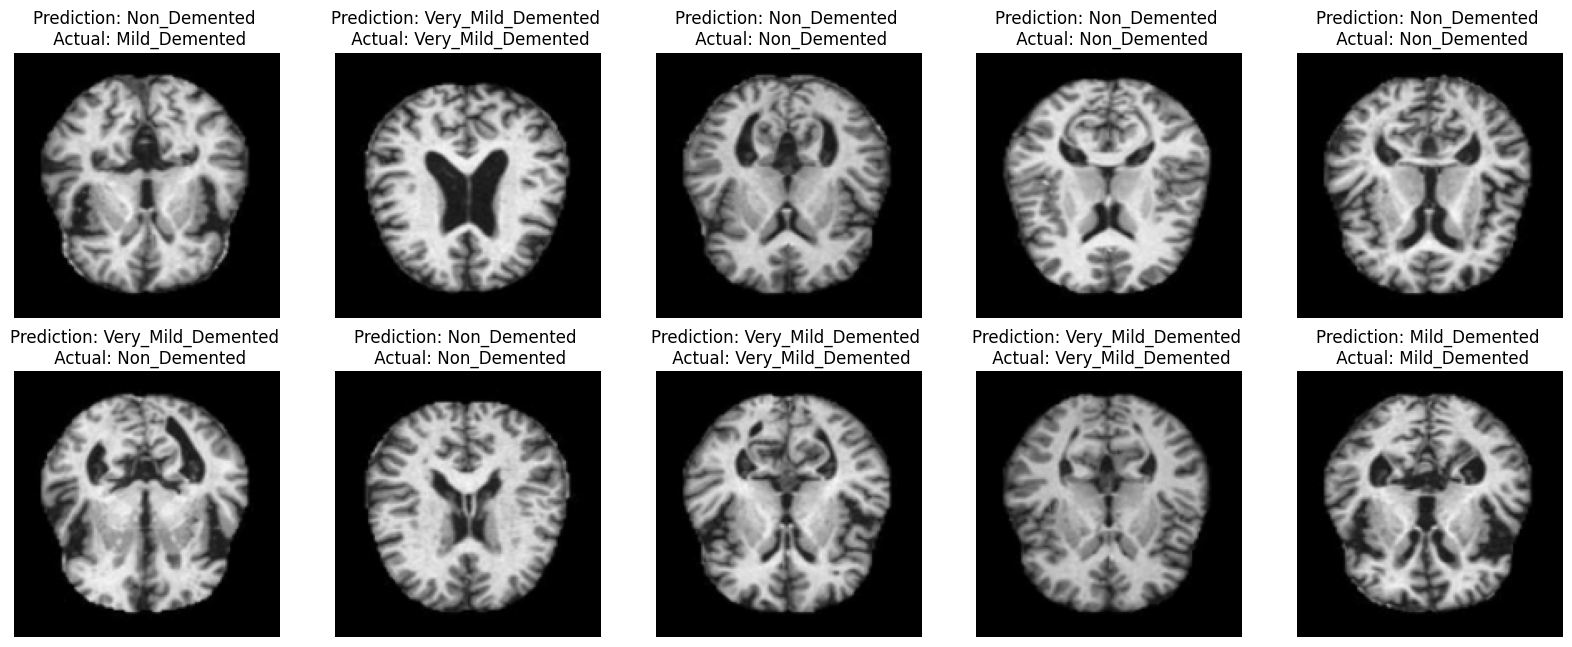

In [31]:
# Plot the prediction vs actual label
plt.figure(figsize=(20, 20))
for i in range(10):
    axs = plt.subplot(5, 5, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    current_prediction = class_names[class_predictions[i]]
    current_label = class_names[label_batch[i]]
    plt.title(f"Prediction: {current_prediction} \n Actual: {current_label}")
    plt.axis('off')

In [32]:
from sklearn.metrics import classification_report, confusion_matrix

# Initialize empty arrays to store predictions and labels
all_predictions = []
all_labels = []

# Iterate through all batches in the test data
for image_batch, label_batch in test_data.as_numpy_iterator():
    predictions = model.predict_on_batch(image_batch)
    class_predictions = np.argmax(predictions, axis=1)
    
    # Append current batch predictions and labels to the arrays
    all_predictions.extend(class_predictions)
    all_labels.extend(label_batch)

# Convert the lists to numpy arrays for easy calculation
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report
class_report = classification_report(all_labels, all_predictions, target_names=class_names)
print("Classification Report:")
print(class_report)


Confusion Matrix:
[[ 86   0   3   2]
 [  1   9   0   0]
 [  5   0 283  22]
 [  9   0  12 208]]
Classification Report:
                    precision    recall  f1-score   support

     Mild_Demented       0.85      0.95      0.90        91
 Moderate_Demented       1.00      0.90      0.95        10
      Non_Demented       0.95      0.91      0.93       310
Very_Mild_Demented       0.90      0.91      0.90       229

          accuracy                           0.92       640
         macro avg       0.92      0.92      0.92       640
      weighted avg       0.92      0.92      0.92       640



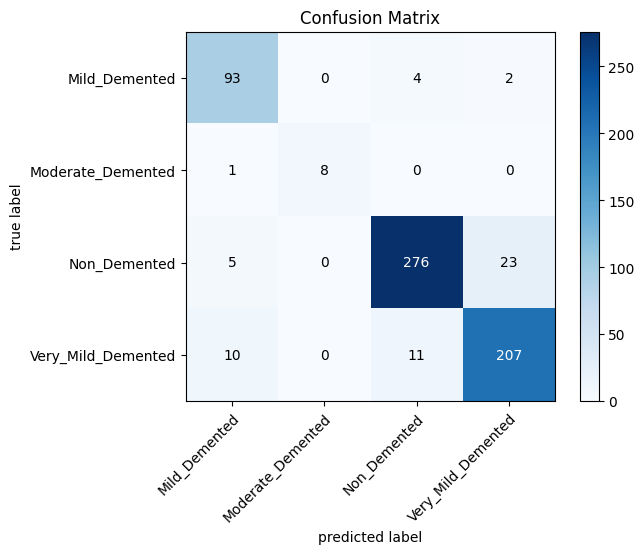

Classification Report:
                    precision    recall  f1-score   support

     Mild_Demented       0.85      0.94      0.89        99
 Moderate_Demented       1.00      0.89      0.94         9
      Non_Demented       0.95      0.91      0.93       304
Very_Mild_Demented       0.89      0.91      0.90       228

          accuracy                           0.91       640
         macro avg       0.92      0.91      0.92       640
      weighted avg       0.91      0.91      0.91       640



In [33]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import pandas as pd

# Initialize empty arrays to store predictions and labels
all_predictions = []
all_labels = []

# Iterate through all batches in the test data
for image_batch, label_batch in test_data.as_numpy_iterator():
    predictions = model.predict_on_batch(image_batch)
    class_predictions = np.argmax(predictions, axis=1)
    
    # Append current batch predictions and labels to the arrays
    all_predictions.extend(class_predictions)
    all_labels.extend(label_batch)

# Convert the lists to numpy arrays for easy calculation
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Convert confusion matrix to a DataFrame for better visualization
conf_matrix_df = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)

# Plot Confusion Matrix
fig, ax = plot_confusion_matrix(conf_mat=conf_matrix, show_normed=False, colorbar=True, class_names=class_names)
plt.title('Confusion Matrix')
plt.show()

# Classification Report
class_report = classification_report(all_labels, all_predictions, target_names=class_names)
print("Classification Report:")
print(class_report)


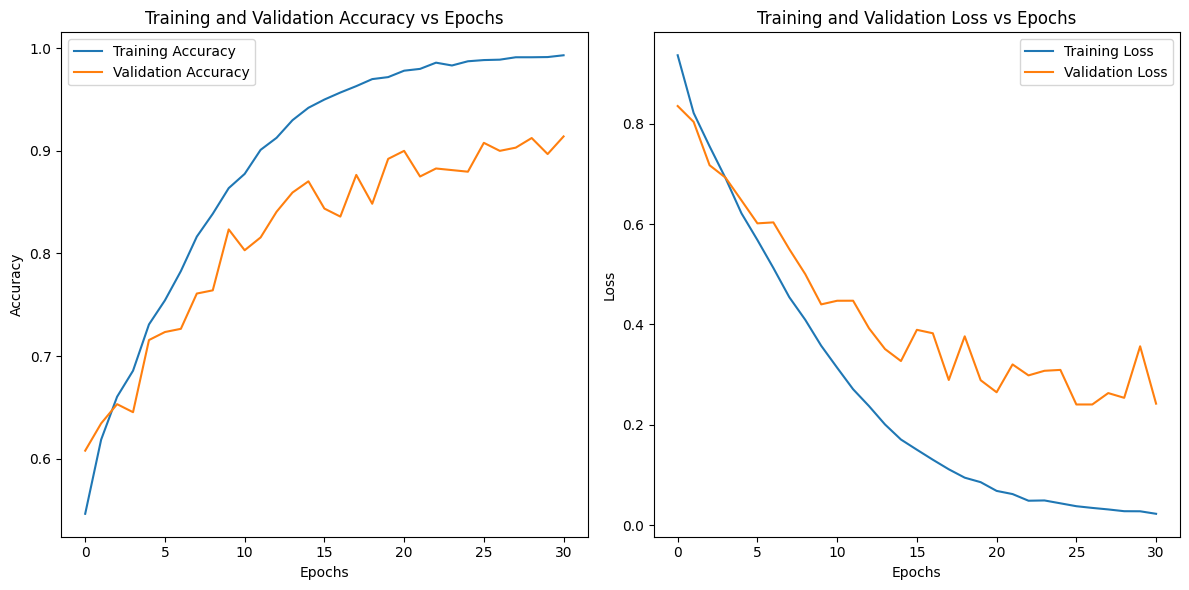

In [34]:
# Get the training history
history_dict = history_fine_tune.history

# Plot training/validation accuracy vs epochs
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training/validation loss vs epochs
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()